In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from deepc_hunt.dynamics import RocketDx
from deepc_hunt import DeePC, Trainer
from deepc_hunt.controllers import npDeePC, npMPC
from deepc_hunt.utils import tensor2np
import matplotlib.pyplot as plt

import gymnasium as gym
import coco_rocket_lander  # need to import to call gym.make()

%matplotlib inline

### Data collection

In [9]:
# initialize data collection
# PRBS INPUT
PRBS_inputs = [(0.33, -1, -0.5), (0.33, 0, -1), (0.75, -1, 1), (0.33, 0, 0.5), 
 (0, -1, 0), (0.33, -1, 1), (0.75, 0, -0.5), (0.75, 0, -1), (0.75, -1, 0.5), (0, 0, 0), 
  (0.75, 1, 0.5), (0, 0, -0.5), (0.33, 1, 0), (0.75, 0, 0), (0.33, 0, 1), (0, -1, 1), (0.75, -1, -1), 
   (0, -1, 0.5), (0.75, 1, 1), (0.33, 1, -0.5), (0, 1, -0.5), (0.33, 0, 0), (0, 1, 1), (0.75, 1, -1), 
    (0.33, 1, 1), (0.75, -1, -0.5), (0.75, 1, -0.5), (0, 0, 1), (0.75, 0, 1), (0.33, -1, 0.5), (0, -1, -1), 
     (0, 1, 0), (0.33, 0, -0.5), (0.75, 0, 0.5), (0, 0, 0.5), (0.33, -1, 0), (0.75, 1, 0), (0.75, -1, 0), 
      (0, 0, -1), (0, 1, -1), (0.33, 1, -1), (0, -1, -0.5), (0.33, -1, -1), (0.33, 1, 0.5), (0, 1, 0.5)]
      
PRBS_interval = 5 # Number of frames per input

############### RANDOM INPUT GENERATOR ###############

# set1 = (0, 0.33, 0.75)
# set2 = (-1, 0, 1)
# set3 = (-1, -0.5, 0,  0.5, 1)

# PRBS_inputs = list(itertools.product(set1, set2, set3))
# random.shuffle(PRBS_inputs)
# print("Number of PRBS inputs is:", len(PRBS_inputs))
# print("PRBS input combinations are:", PRBS_inputs)

#######################################################

collected = True # Change to False if you want to collect data

if not collected:

      n = 6 # states
      m = 3 # inputs
      p = 6 # outputs

      T_past = 1 # number of past measurements (also called T_ini)
      T_future = 10 # number of future measurements (also called K)

      L = T_past + T_future # length of a data sequence
      print("Length of a data sequence:", L)

      T_hankel =  PRBS_interval*len(PRBS_inputs) #(m*L + n) + L - 1 # number of measurements used to fill Hankel Matrix

      print("Number of measurements to fill Hankel Matrix:", T_hankel)

      rank_hankel_theoretical = m*L + n # theoretical maximum rank of Hankel Matrix
      print("Theoretical maximum rank of Hankel Matrix:", rank_hankel_theoretical)

      u_data = np.zeros((T_hankel,m))
      y_data = np.zeros((T_hankel,p))
      print("Shape of u_data:", np.shape(u_data))
      print("Shape of y_data:", np.shape(y_data))


      # make environment and wrap video so that we can replay them later

      args = {
      "initial_position": (0.5, 0.4, 0)
      }

      env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
      env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="DeePC_Data_Collection")

      # simulate
      step_count = 0
      max_steps = T_hankel

      obs, info = env.reset(seed=0)  # specify a random seed for consistency

      while True:
            landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]

            # PRBS INPUT
            action = np.array(PRBS_inputs[step_count//PRBS_interval])
            # print("Used PRBS input number:", step_count//PRBS_interval)

            # collect data
            u_data[step_count] = action
            y_data[step_count] = obs[0:6]

            next_obs, rewards, done, _, info = env.step(action)

            # check if simulation ended
            step_count += 1
            if done or (step_count >= max_steps):
                  break

            # update observation
            obs = next_obs

            env.close()  

### Initialise controller

In [10]:
q = torch.Tensor([100,10,5,1,3000,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
r = torch.Tensor([0.01,0.01,0.01]) # 3-tuple (F_E, F_S, phi)
q_np = tensor2np(q)
r_np = tensor2np(r)

n = 6 # states
m = 3 # inputs
p = 6 # outputs

Tini = 1 # number of past measurements (also called T_ini)
Tf = 10 # number of future measurements (also called K)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_batch = 2

ud = np.genfromtxt('data/rocket_ud.csv', delimiter=',')
yd = np.genfromtxt('data/rocket_yd.csv', delimiter=',')

# y_constraints = np.ones(Tf*p)*1e5 #Unconstrained
# u_constraints = np.ones(Tf*m)
y_upper = np.kron(np.ones(Tf), np.array([33,26.6,100,100,0.6,100]))
y_lower = np.kron(np.ones(Tf), np.array([0,7,-100,-100,-0.6,-100]))
u_upper = np.kron(np.ones(Tf), np.array([1,1,1]))
u_lower = np.kron(np.ones(Tf), np.array([0,-1,-1]))
y_constraints = (y_lower, y_upper)
u_constraints = (u_lower, u_upper)
Trained = True


In [11]:
# For training
controller = DeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic_y=True, stochastic_u=False, q=q, r=r,
).to(device)

epochs = 100
time_steps = 20
rocket = RocketDx(true_model=False)

### Run DeePC-Hunt using the the rocket surrogate dynamics

In [12]:
initial_params = {'lam_g1':50, 'lam_g2':50, 'lam_y':1000}
uref = torch.zeros(m)
uref = uref.repeat(n_batch, Tf)
yref = torch.Tensor([16.6,7.47,0,0,0,0])
yref = yref.repeat(n_batch, Tf)

# Tune regularization params
controller.initialise(lam_g1=initial_params['lam_g1'], lam_g2=initial_params['lam_g2'], lam_y=initial_params['lam_y'])
deepc_tuner = Trainer(controller=controller, env=rocket)
final_params = deepc_tuner.run(epochs=epochs, time_steps=time_steps, uref=uref, yref=yref)
Trained = True

  0%|                                                                       | 0/100 [00:00<?, ?it/s]

param 0 has shape torch.Size([2, 60, 60])
param 1 has shape torch.Size([2, 30, 30])
param 2 has shape torch.Size([2, 3])
param 3 has shape torch.Size([2, 6])
param 4 has shape torch.Size([2, 60])
param 5 has shape torch.Size([2, 30])
param 6 has shape torch.Size([2, 1])
param 7 has shape torch.Size([2, 1])
param 8 has shape torch.Size([2, 1])
param 0 has shape torch.Size([2, 60, 60])
param 1 has shape torch.Size([2, 30, 30])
param 2 has shape torch.Size([2, 3])
param 3 has shape torch.Size([2, 6])
param 4 has shape torch.Size([2, 60])
param 5 has shape torch.Size([2, 30])
param 6 has shape torch.Size([2, 1])
param 7 has shape torch.Size([2, 1])
param 8 has shape torch.Size([2, 1])
param 0 has shape torch.Size([2, 60, 60])
param 1 has shape torch.Size([2, 30, 30])
param 2 has shape torch.Size([2, 3])
param 3 has shape torch.Size([2, 6])
param 4 has shape torch.Size([2, 60])
param 5 has shape torch.Size([2, 30])
param 6 has shape torch.Size([2, 1])
param 7 has shape torch.Size([2, 1])
pa

  0%|                                                                       | 0/100 [00:03<?, ?it/s]

param 0 has shape torch.Size([2, 60, 60])
param 1 has shape torch.Size([2, 30, 30])
param 2 has shape torch.Size([2, 3])
param 3 has shape torch.Size([2, 6])
param 4 has shape torch.Size([2, 60])
param 5 has shape torch.Size([2, 30])
param 6 has shape torch.Size([2, 1])
param 7 has shape torch.Size([2, 1])
param 8 has shape torch.Size([2, 1])
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


SolverError: Solver ecos errored.

### Build New DeePC controllers

Take the final and initial regularisation parameters and build faster implementation in NumPy and CvxPy

In [ ]:
# Trained controller in NumPy
initial_params = {'lam_g1':50, 'lam_g2':10.3, 'lam_y':1000}
trained_controller = npDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n=n
)
trained_controller.setup(Q=np.diag(q_np), R=np.diag(r_np), 
    lam_g1=tensor2np(initial_params['lam_g1']), 
    lam_g2=tensor2np(initial_params['lam_g2']), 
    lam_y=tensor2np(initial_params['lam_y'])
)

### MPC Controller for testing

In [ ]:
x_eq = np.array([16.6,7.47,0,0,0,0]) # Landing position
u_eq = np.array([0,0,0])

A, B = rocket.linearise(x_eq=x_eq, u_eq=u_eq, discrete=True)
print("A:\n", A.round(3), "\n"*2, "B:\n", B.round(3))

mpc = npMPC(
        A=A, B=B, Q=np.diag(q_np), R=np.diag(r_np), N=Tf, 
        u_constraints=u_constraints, y_constraints=y_constraints
)
mpc.setup()

A:
 [[1.    0.    0.017 0.    0.    0.   ]
 [0.    1.    0.    0.017 0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.017]
 [0.    0.    0.    0.    0.    1.   ]] 

 B:
 [[ 0.     0.     0.   ]
 [ 0.008  0.     0.   ]
 [ 0.     0.02   0.   ]
 [ 1.013  0.     0.   ]
 [ 0.    -0.     0.   ]
 [ 0.    -0.013  0.   ]]


### Showcase trained controller on real simulation

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

import coco_rocket_lander  # need to import to call gym.make()

args = {
    "initial_position": (0.6, 0.9, 0.1),  # 3-tuple (x, y, theta)
    "enable_wind": False,
}
vids = 1
data_driven = True
root = 'DeePC' if data_driven else 'MPC'

# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
env = gym.wrappers.RecordVideo(env, '../videos/' + root, episode_trigger = lambda x: True, name_prefix=root)
obs, info = env.reset()  # specify a random seed for consistency

# initialize variables
step_count = 0
max_steps = 1200
touched_ground = 0
landing_mode = 0
final_landing_position = []

# landing parameters
hover_height = 0
x_tol = 0.5
x_dot_tol = 0.3
theta_tol = 0.1
fig = []

#Initial state for DeePC
u_past_sim = np.zeros(3*Tini)
y_past_sim = np.tile(obs[0:6],Tini)

torch_states = []
real_states = []

# simulate
pbar = tqdm(range(max_steps))
for i in pbar:

  # Get references for tracking
  landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
  deepc_reference = [0,0,0,0,0,0]
  deepc_reference[0] = landing_position[0]
  deepc_reference[1] = landing_position[1] 
  deepc_reference = np.tile(deepc_reference,Tf)
  uref = np.zeros(m*Tf)     

  # Compute control action depending on data-driven or model-based policy
  if data_driven:
    action, _ = trained_controller.solve(y_ref=deepc_reference, u_ref=uref, y_ini=y_past_sim[-p:], u_ini=u_past_sim)
  else:
    action, _ = mpc.solve(y_ref=deepc_reference, u_ref=uref, y_ini=y_past_sim[-p:])

  # store input & output for DeePC
  u_past_sim = np.append(u_past_sim[3:], action)
  y_past_sim = np.append(y_past_sim, obs[0:6])

  # # apply action
  fig.append(env.render())
  next_obs, rewards, done, _, info = env.step(action)
  obs = next_obs

  # check if simulation ended
  step_count += 1
  if done or (step_count > max_steps):
    break

# Save trajectory for plotting
real_states = np.array(real_states)
torch_states = np.array(torch_states)
env.close()  # video saved at this step

 43%|████▎     | 515/1200 [01:09<01:28,  7.77it/s]

Moviepy - Building video /Users/michaelcummins/DeePC-HUNT/videos/DeePC/DeePC-episode-0.mp4.
Moviepy - Writing video /Users/michaelcummins/DeePC-HUNT/videos/DeePC/DeePC-episode-0.mp4



 43%|████▎     | 515/1200 [01:10<01:34,  7.25it/s]

Moviepy - Done !
Moviepy - video ready /Users/michaelcummins/DeePC-HUNT/videos/DeePC/DeePC-episode-0.mp4


### Display final landing position of rocket

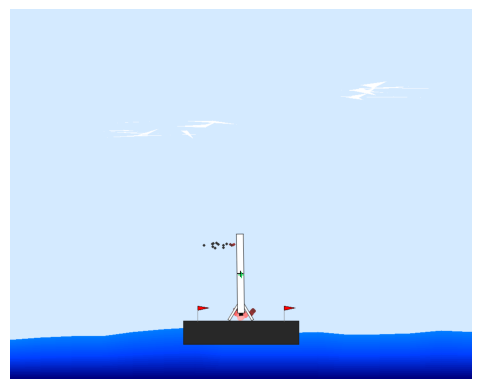

In [ ]:
plt.imshow(fig[-1])
plt.axis('off')
if not data_driven:
    if rocket.true_model:
        plt.savefig('images/mpc/mpc_good.png') 
    else: 
        plt.savefig('images/mpc/mpc_bad.png')
else:
    if Trained:
        if rocket.true_model:
            plt.savefig('images/deepc/deepc_good.png') 
        else: 
            plt.savefig('images/deepc/deepc_bad.png')
    else: plt.savefig('images/deepc/rocket_untrained.png')
plt.show()

### Trajectory Plotting

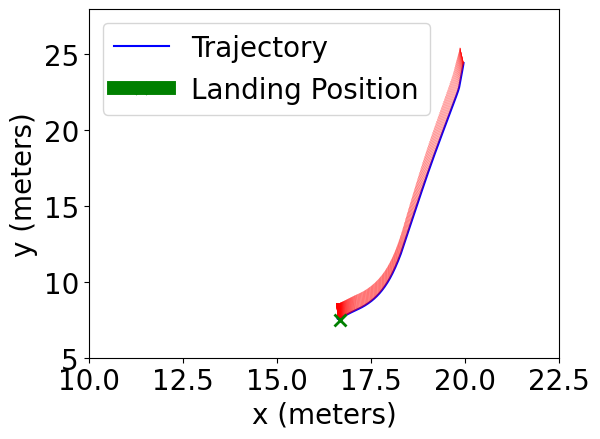

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# Plot the trajectory of rocket depending on policy
Trained = True
row = len(y_past_sim)/6
x_traj_deepc = y_past_sim.reshape(int(row),6)

plt.plot(x_traj_deepc[:,0], x_traj_deepc[:,1], c='blue', label='Trajectory')
for step in range(x_traj_deepc.shape[0]):
    plt.plot(
        [x_traj_deepc[step,0], x_traj_deepc[step,0]+np.sin(-x_traj_deepc[step,4])],
        [x_traj_deepc[step,1], x_traj_deepc[step,1]+np.cos(-x_traj_deepc[step,4])],
        c='red', linewidth=0.2
    )
plt.plot(landing_position[0], landing_position[1], c='green', marker='x', markersize=8, markeredgewidth=2, linewidth=10, label='Landing Position')
plt.legend(loc='upper left')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.xlim(10,22.5)
plt.ylim(5,28)
plt.tight_layout()

if not data_driven:
    if rocket.true_model:
        plt.savefig('images/mpc/mpc_good_traj.png') 
    else: 
        plt.savefig('images/mpc/mpc_bad_traj.png')
else:
    if Trained:
        if rocket.true_model:
            print('saving')
            plt.savefig('images/deepc/deepc_good_traj.png') 
        else: 
            plt.savefig('images/deepc/deepc_bad_traj.png')
    else: 
        plt.savefig('images/deepc/rocket_untrained_traj.png')
plt.show()